In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import netCDF4 as nc
import xarray as xr
import scipy.ndimage
import scipy as sp
import alphashape
from scipy import interpolate
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')


In [2]:
# Read in radar data

DerwaelData = pd.read_csv('../Data/IceRiseClara_xyH.txt', delimiter=" ")


In [3]:
# Read in the unchanged netcdf file

ds = nc.Dataset('/Users/clara.henry/Documents/Derwael/Code/DerwaelBCs.nc')
bedrock_old = np.array(ds.variables['bedrock'][:])
upper_surface_old = np.array(ds.variables['zs0'][:])
lower_surface_old = np.array(ds.variables['zb0'][:])
X = np.array(ds.variables['x'][:])
Y = np.array(ds.variables['y'][:])


In [4]:
# Read in grounding line and make polygon

dfGL = pd.read_csv("/Users/clara.henry/Documents/Derwael/Data/GroundingLine.csv")
points = np.column_stack((list(dfGL["Points:0"])[::10], list(dfGL["Points:1"])[::10]))
alpha = 0.95 * alphashape.optimizealpha(points)
hull = alphashape.alphashape(points, alpha)
hull_pts = hull.exterior.coords.xy
hull_pts = hull_pts

for i in range(len(hull_pts[0])):
    hull_pts[0][i] = hull_pts[0][i]
    hull_pts[1][i] = hull_pts[1][i]


/Users/clara.henry/opt/anaconda3/lib/python3.9/site-packages/shapely/ops.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  source = iter(source)
/Users/clara.henry/opt/anaconda3/lib/python3.9/site-packages/alphashape/optimizealpha.py:41: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return all([polygon.intersects(point) for point in points])


In [5]:
# Convert hull to a dataframe

GL_x = hull_pts[0].tolist()
GL_y = hull_pts[1].tolist()

df_hull = pd.DataFrame(
    {'X': GL_x,
     'Y': GL_y
    })


In [6]:
# Flip arrays

bedrock_old = np.flipud(bedrock_old)
upper_surface_old = np.flipud(upper_surface_old)
lower_surface_old = np.flipud(lower_surface_old)
Y = Y[::-1]

In [7]:
# Choose the points for interpolation

Index1 = 98283
Index2 = 112348
Index3 = 99635

# Derive the equations for generating the arc of data

m1 = (DerwaelData["Y"][Index2] - DerwaelData["Y"][Index1])/(DerwaelData["X"][Index2] - DerwaelData["X"][Index1])

# Line between the two points:

def line1(x):
    return m1 * ( x - DerwaelData["X"][Index1]) + DerwaelData["Y"][Index1]

# Find midpoint

xm = (DerwaelData["X"][Index1] + DerwaelData["X"][Index2])/2.0
ym = (DerwaelData["Y"][Index1] + DerwaelData["Y"][Index2])/2.0

m2 = -1.0 / m1

def line2(x):
    return m2 * ( x - xm) + ym

ArcCentre_x, ArcCentre_y = 0.969e6, line2(0.969e6)

# Calculate the arc radius

rad = np.sqrt((ArcCentre_x - DerwaelData["X"][Index1])**2 + (ArcCentre_y - DerwaelData["Y"][Index1])**2)

# Define the circle equation (note: only need the positive sqrt here)

def Circle(coord, with_x):
    if with_x == True:
        return ArcCentre_y + np.sqrt(rad**2 - (coord- ArcCentre_x)**2)
    elif with_x == False:
        return ArcCentre_x + np.sqrt(rad**2 - (coord- ArcCentre_y)**2)

# Generate coordinates along the arc

Xarc1 = []
Yarc1 = []
Harc1 = []

for x in np.arange(DerwaelData["X"][Index1], DerwaelData["X"][Index2], 100):
    Xarc1.append(x)
    Yarc1.append(Circle(x, True))
    
# Generate heights along arc 1

mH1 = (DerwaelData["H"][Index2] - DerwaelData["H"][Index1])/(DerwaelData["X"][Index2] - DerwaelData["X"][Index1])

def Height(x):
    return DerwaelData["H"][Index1] + mH1 * (x - DerwaelData["X"][Index1])

for x in np.arange(DerwaelData["X"][Index1], DerwaelData["X"][Index2], 100):
    Harc1.append(Height(x))

# Generate heights along arc 2 (generate using y this time)

Xarc2 = []
Yarc2 = []
Harc2 = []

for y in np.arange(DerwaelData["Y"][Index3], DerwaelData["Y"][Index2], 100):
    Yarc2.append(y)
    Xarc2.append(Circle(y, False))
    
mH2 = (DerwaelData["H"][Index2] - DerwaelData["H"][Index3])/(DerwaelData["Y"][Index2] - DerwaelData["Y"][Index3])

for y in np.arange(DerwaelData["Y"][Index3], DerwaelData["Y"][Index2], 100):
    Harc2.append(Height(x))
    

In [8]:
# Make a dataframe of the new data

ListedData1 = {'X': Xarc1, 'Y': Yarc1, 'H': Harc1}
ListedData2 = {'X': Xarc2, 'Y': Yarc2, 'H': Harc2}
GeneratedData1 = pd.DataFrame(data=ListedData1)
GeneratedData2 = pd.DataFrame(data=ListedData2)
DerwaelData = DerwaelData.append(GeneratedData1, ignore_index = True)
#DerwaelData = DerwaelData.append(GeneratedData2, ignore_index = True)


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_9387/1885566515.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DerwaelData = DerwaelData.append(GeneratedData1, ignore_index = True)


In [9]:
# Interpolate data and apply subtraction

DerwaelData['zs'] = 0
DerwaelData['zb'] = 0

f = interpolate.interp2d(X, Y, upper_surface_old, kind='linear')

for i in range(len(DerwaelData)):
    DerwaelData['zs'][i] = f(DerwaelData['X'][i], DerwaelData['Y'][i])

DerwaelData['zb'] = DerwaelData['zs'] - DerwaelData['H']

# Create the grid space

x = np.linspace(920500.0, 998000.0, 156)
y = np.linspace(1880000.0, 1966000.0, 173)
grid_x, grid_y = np.mgrid[920500.0:998000.0:156j, 1880000.0:1966000.0:173j]
thickness = scipy.interpolate.griddata((DerwaelData["X"], DerwaelData["Y"]), DerwaelData["H"], (grid_x, grid_y), method='linear')

lowersurface = upper_surface_old - thickness.T


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_9387/854014285.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DerwaelData['zs'][i] = f(DerwaelData['X'][i], DerwaelData['Y'][i])


In [10]:
# Choose an area to cut out: the grounding line x=9.6e5 and y=1.95e6 
# (note: the GL data coords moves anti-clockwise starting in the SW)

# Find points that intersect x=9.6e5 and y=1.95e6:

x_cut = 9.6e5
y_cut = 1.945e6

for i in range(len(df_hull)):
    if df_hull['X'][i] > x_cut:
        pass
    else:
        break

i_n = i

for i in range(i_n + 1, len(df_hull)):
    if df_hull['X'][i] < x_cut:
        pass
    else:
        break

GL_x_cut_index = i
        
for i in range(len(df_hull)):
    if df_hull['Y'][i] < y_cut:
        pass
    else:
        break

i_n = i

for i in range(i_n + 1, len(df_hull)):
    if df_hull['Y'][i] > y_cut:
        pass
    else:
        break

GL_y_cut_index = i


In [11]:
# Create a dataframe of the hull points of interest

df_hull_subset = df_hull[GL_x_cut_index:GL_y_cut_index]

ExtraCoords = {'X': [df_hull["X"][GL_y_cut_index], x_cut, x_cut], 'Y':[y_cut, y_cut, df_hull["Y"][GL_x_cut_index]]}
ECdf = pd.DataFrame(data=ExtraCoords)
df_hull_subset = df_hull_subset.append(ECdf, ignore_index = True)


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_9387/3562679844.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_hull_subset = df_hull_subset.append(ECdf, ignore_index = True)


In [12]:
# Create a hull out of the new subset

points_sub = np.column_stack((list(df_hull_subset["X"]), list(df_hull_subset["Y"])))
alpha_sub = 0.8 * alphashape.optimizealpha(points_sub)
hull_sub = alphashape.alphashape(points_sub, alpha_sub)
hull_pts_sub = hull_sub.exterior.coords.xy

hull_pts_sub = hull_pts_sub

for i in range(len(hull_pts_sub[0])):
    hull_pts_sub[0][i] = hull_pts_sub[0][i]
    hull_pts_sub[1][i] = hull_pts_sub[1][i]

poly_sub = Polygon(zip(list(hull_pts_sub[0]), list(hull_pts_sub[1])))


/Users/clara.henry/opt/anaconda3/lib/python3.9/site-packages/shapely/ops.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  source = iter(source)
/Users/clara.henry/opt/anaconda3/lib/python3.9/site-packages/alphashape/optimizealpha.py:41: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return all([polygon.intersects(point) for point in points])


In [13]:
lowersurface = lowersurface.T

In [14]:
# Set everything outside the poygon to NaN

for i in range(len(x)):
    for j in range(len(y)):
        boolean = poly_sub.contains(Point(x[i], y[j]))
        if boolean == False:
            lowersurface[i][j] = "nan"


(1920000.0, 1980000.0)

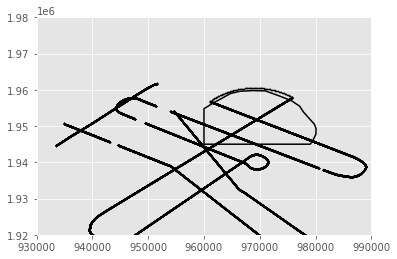

In [15]:
# Plot the data

x_cut = 502

fig, ax = plt.subplots(1, 1)
ax.scatter(DerwaelData["X"], DerwaelData["Y"], c='black', s=1) 
ax.plot(hull_pts_sub[0], hull_pts_sub[1], color='black')
ax.set_xlim(0.93e6,0.99e6)
ax.set_ylim(1.92e6,1.98e6)



/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_9387/4149489416.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS)


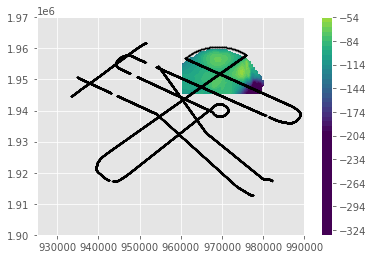

In [16]:
# Plot interpolated data with generated data

fig, ax = plt.subplots(1, 1)
CS = ax.contourf(grid_x, grid_y, lowersurface, levels=50, vmin=-200, vmax=-30)
ax.scatter(DerwaelData["X"], DerwaelData["Y"], c='black', s=1) 
ax.set_xlim(0.925e6,0.99e6)
ax.set_ylim(1.9e6,1.97e6)
cbar = fig.colorbar(CS)


In [21]:
# Export as a netcdf file

lowersurface = np.flipud(lowersurface)

lower_bed_sub = xr.DataArray(
    data=lowersurface.T,
    dims=['y', 'x'],
    coords=dict(
        x=X,
        y=Y
    
    )
)

lower_bed_sub.to_netcdf('DerwaelFixedInterpolation.nc')
